# Assignment 2 Part 2

###  In this part of assignment you'll be determining the intrinsic and extrinsic parameters of a your mobile phone camera using camera calibration techniques. 
### Undergrad students have to strictly follow the handout and implement the procedure outlined in the handout. Grad students can follow the handout and get full marks but they are free to experiment and they can look at other ways of finding the projection matrix but keep in mind that you are not allowed to copy code and you should able to explain every step of your implementation.
### For this assignment we are using the direct linear transformation method

In [1]:
import matplotlib
import cv2
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import image as mpimg
from matplotlib.pyplot import figure
import seaborn as sns
import numpy as np
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
%matplotlib notebook

## Part 1 (30 marks for undergrad) (20 marks for grad)
### Take image of a calibration object with your camera phone. Unlike shown in the lecture slides here you are required to choose an appropriate 3D calibration object (i.e. a nonplanar object, a rubiks cube for example) so that the world points on that object span a 3-dimensional space, and the image points are easy to mark. Place the calibration object on a horizontal plane, such as a tabletop, or floor, to take the image. Mark at least 25 image points as carefully as possible and establish their world coordinates in millimeters. 
### From this data, compute the camera matrix P. Show the original points and the back-projected camera points on a single image and compute the average re-projection error.

In [2]:
def error_func(pt1,pt2):
    error_x = (pt1[0]-pt2[0])**2
    error_y = (pt1[1]-pt2[1])**2
    err = np.sum(error_x + error_y)
    return err

9.673026465199225


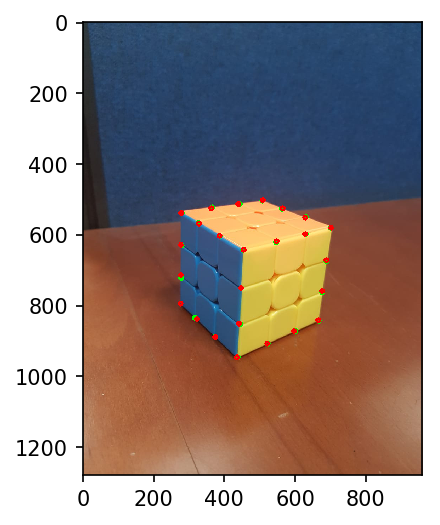

In [3]:
rubik = np.array(mpimg.imread('Rubiks.jpg')) #Image is 960 x 1280px
rubik.setflags(write=1)

pixels = np.array([
    [275,315,373,436,521,599,665,277,444,675,278,446,687,279,326,386,451,545,628,699,364,442,506,561,629],
    [795,835,889,947,908,873,843,723,854,763,631,751,675,539,567,604,644,622,599,581,523,514,504,527,551],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
])

worldpts = np.array([
    [0,1,2,3,3,3,3,0,3,3,0,3,3,0,1,2,3,3,3,3,0,0,0,1,2], # x
    [0,0,0,0,1,2,3,0,0,3,0,0,3,0,0,0,0,1,2,3,1,2,3,3,3], # y
    [0,0,0,0,0,0,0,1,1,1,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3], # z
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
])

worldpts = 18.1666666667*np.array(worldpts)
worldpts[-1] = worldpts[-1]/18.1666666667
worldpts = worldpts.T # 25 x 4
pixels = pixels.T # 25 x 3


P = np.zeros((2*(pixels.shape[0]),12))
rows = 0
for i in range(pixels.shape[0]):
    x = pixels[i][0]
    y = pixels[i][1]

    X = worldpts[i][0]
    Y = worldpts[i][1]
    Z = worldpts[i][2]

    P[rows] = np.array([X,Y,Z,1,0,0,0,0,-x*X,-x*Y,-x*Z,-x])
    rows+=1
    P[rows] = np.array([0,0,0,0,X,Y,Z,1,-y*X,-y*Y,-y*Z,-y])
    rows+=1
    
    
U, S, V = np.linalg.svd(P, full_matrices = True)
End_col = V[V.shape[0]-1,:]

P = End_col.reshape((3,4))

worldpts = worldpts.T # 4x25
projectedpts = np.matmul(P,worldpts) # 3x25
projectedpts = projectedpts/projectedpts[-1]
# print(projectedpts)

pixels = pixels.T # 3x25
err = error_func(pixels,projectedpts)
err = err/pixels.shape[1]
print(err)

pixels = pixels.T # 25 x 3
projectedpts = np.asarray(projectedpts.T,dtype = int) 
for pt in pixels:
    cv2.circle(rubik,(pt[0],pt[1]),5,(0,255,0),5)
for pt in projectedpts:
    cv2.circle(rubik,(pt[0],pt[1]),5,(255,0,0),5)
    
figure(dpi = 150)
plt.imshow(rubik)
plt.show()


## Part 2 (10 marks for both)
### Since we are using direct linear transformation, you are required to implement QR decomposition of a matrix

In [4]:
def qr_decomp(A): #you can decide what input this function take
    m, n = A.shape
    Q = np.eye(m)
    for i in range(n - (m == n)):
        H = np.eye(m)
        H[i:, i:] = make_householder(A[i:, i])
        Q = np.dot(Q, H)
        A = np.dot(H, A)
    return Q, A
 
def make_householder(a):
    v = a / (a[0] + np.copysign(np.linalg.norm(a), a[0]))
    v[0] = 1
    H = np.eye(a.shape[0])
    H -= (2 / np.dot(v, v)) * np.dot(v[:, None], v[None, :])
    return H
 
# Reference help
# https://rosettacode.org/wiki/QR_decomposition#Python

## Part 3 (30 marks for undergrad) (20 marks for grad)
### Compute camera center C, intrinsic matrix K and Rotation matrix R. Generate a 3D figure which shows the calibration points, the camera center and the orientation of the camera in 3D (You also have to plot the points for 3d calibration object as well)

In [5]:
U, S, V = np.linalg.svd(P, full_matrices = True)
End_col = V[V.shape[0]-1,:]

C = End_col.reshape((4,1)) #This is my camera centre

C= C/C[-1]

print('C:\n',C)

KR = P[0:3,0:3]
KR = np.linalg.inv(KR)
# print(P)
# print(KR)

R, K = qr_decomp(KR)
R = np.linalg.inv(R)
K = np.linalg.inv(K)
K = K/K[2][2]
print('K:\n', K.round(6))
print('R:\n', R.round(6))




C:
 [[170.44716584]
 [-89.86988633]
 [118.81044264]
 [  1.        ]]
K:
 [[ 1.08360008e+03  1.30298800e+00  4.98894150e+02]
 [ 0.00000000e+00 -1.06989920e+03  5.35463790e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
R:
 [[-0.623356 -0.77893  -0.06853 ]
 [ 0.279872 -0.140419 -0.949713]
 [ 0.730136 -0.611189  0.305531]]


## Part 4 (20 marks for both)
### Search for the sensor information of your camera on the web. From this information, compute the focal length in mm. Also compute the angle between the image axes. The following link may be useful to look up sensor information:
https://www.ephotozine.com/article/complete-guide-to-image-sensor-pixel-size-29652
### now re-plot everything along with the principal point of camera

In [6]:
width = 5.5 # in mm
height = 4.1
Img_size = (960,1280)

mx = Img_size[0]/height
my = Img_size[1]/width


fx = abs(K[0,0])/mx
fy = abs(K[1,1])/my
print(fx, fy)

4.627875331686201 4.597223108625419


## Part 5 (10 marks for both)
### Suggest a few ways to minimize the error in this whole procedure. Since you are suggesting these, go back and try repeating/tweaking the whole algorithm and see if the things you suggest actually have an impact on the solution (it is perfectly fine if your propositions are not resulting in anything positive) (Suggest at least 2)

In [7]:
# Firstly what we can do is take more correspondences, 
# for example here we are taking 25 so we can take 37 points instead
# Other than that we can take alot more images at alot more images at alot more angles
# Use objects withh finer markings so our precision is much more
# Take more precise measurements

## Part 6 (Grad Only, 20 marks for this part)
### Look up the existing ways of camera calibration and draw a comparisons between the one you've implemented above. While comparing the two algorithms, you should be able the explain the computation/space complexity of the two algorithms, the assumptions that are kept in both algorithms and under what circumstances each would fail. You should also explain the equations involved in both algorithms.
### In case you have opted for not following the handout (i.e looking up and implementing your own algo) you can draw comparison between the algorithm that you've written and the one proposed in the handout (DLT)

In [9]:
# your answer/code goes here